In [73]:
from collections import OrderedDict
import re
import os

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import torch
from tqdm.notebook import tqdm

import sys
sys.path.append("../../")  # 或者 append 到你的 mamba_mod 根路径

from eval import get_run_metrics, read_run_dir, get_model_from_run
from plot_utils import basic_plot, collect_results, relevant_model_names

import scienceplots
plt.style.use(['science', 'no-latex', 'light'])

%matplotlib inline
%load_ext autoreload
%autoreload 2

sns.set_theme('notebook', 'darkgrid')
palette = sns.color_palette('colorblind')

run_dir = "../models/"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [74]:
df = read_run_dir(run_dir)
df  # list all the runs in our run_dir

,run_id,task,model,kwargs,num_tasks,num_examples,n_dims,n_layer,n_head,run_name
0,420fe524-1de3-4eae-ab6c-e02145a4999c,gkr_gpt2_fast,Transformer,,-1,-1,20,4,8,gkr_gpt2_fast_debug
1,01792bc8-29fb-4d6a-b590-537dcf997170,linear_regression,Transformer,,-1,-1,20,12,8,linear_regression_standard


# Plot pre-computed metrics

In [75]:
run_path = os.path.join(run_dir, task, run_id)
print(f"Run path: {run_path}")


Run path: ../models/linear_regression/01792bc8-29fb-4d6a-b590-537dcf997170


In [76]:
print("Available models in metrics:", list(metrics["standard"].keys()))
print("Expected models:", models)


Available models in metrics: []
Expected models: []



=== Processing task: gkr_gpt2_fast ===
Valid run path: ../models/gkr_gpt2_fast/420fe524-1de3-4eae-ab6c-e02145a4999c
gkr_gpt2_fast_debug 420fe524-1de3-4eae-ab6c-e02145a4999c


100%|██████████| 1/1 [00:00<00:00, 33288.13it/s]

[Plot] standard models: ['gpt2_embd=64_layer=4_head=8', 'NN_n=3_uniform', 'averaging']


<Figure size 2000x1200 with 0 Axes>

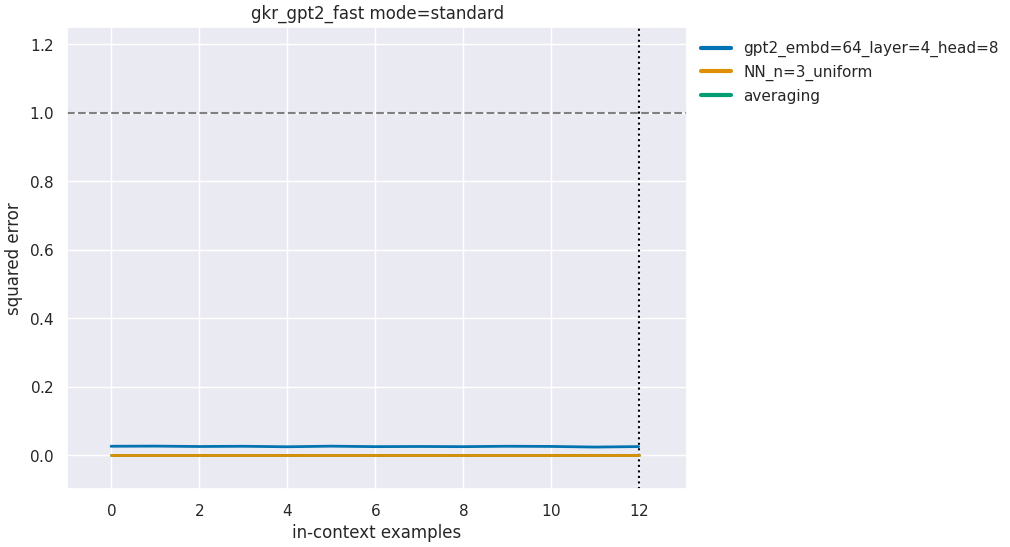


=== Processing task: linear_regression ===
Valid run path: ../models/linear_regression/01792bc8-29fb-4d6a-b590-537dcf997170
linear_regression_standard 01792bc8-29fb-4d6a-b590-537dcf997170


100%|██████████| 15/15 [00:00<00:00, 225500.22it/s]

[Warning] No model names found for task linear_regression


In [77]:
import os
import yaml
import torch
import matplotlib.pyplot as plt
from munch import Munch

run_base = "../models"
xlim = 200  # 你可以设置为 None

for task in os.listdir(run_base):
    task_path = os.path.join(run_base, task)
    if not os.path.isdir(task_path):
        continue

    print(f"\n=== Processing task: {task} ===")

    run_ids = []
    run_paths = []

    for run_id in os.listdir(task_path):
        run_path = os.path.join(task_path, run_id)
        config_path = os.path.join(run_path, "config.yaml")
        if os.path.exists(config_path):
            run_ids.append(run_id)
            run_paths.append(run_path)
            print("Valid run path:", run_path)

    if not run_paths:
        print(f"[Warning] No valid runs found under task {task}")
        continue

    def valid_row(r):
        return r.task == task and r.run_id in run_ids

    def rename_mamba(x, r=None):
        return x if 'mamba' not in x else 'Mamba'

    # 注意：df 是你之前 collect 出的所有 run 表，需定义或传入
    metrics = collect_results(run_base, df, valid_row=valid_row, rename_model=lambda x: rename_mamba(x, None),
                              no_recompute=True, xlim=xlim)

    # 从第一个 run 中取维度和点数信息（默认所有 run 参数一致）
    _, conf = get_model_from_run(run_paths[0], only_conf=True)
    n_dims = conf.model.n_dims
    n_train_points = conf.training.curriculum.points.end

    models = relevant_model_names.get(task, []).copy()
    if not models:
        print(f"[Warning] No model names found for task {task}")
        continue

    # === 可视化 ===
# 重命名模型名
    standard_metric = {
        rename_mamba(k): v for k, v in metrics["standard"].items()
    }
    available_models = list(standard_metric.keys())

    # 你之前期望的模型名
    models_to_plot = available_models

    if not models_to_plot:
        print(f"[Skip] No matching models in standard metric for {task}")
    else:
        print(f"[Plot] standard models: {models_to_plot}")

        plt.figure(figsize=(20, 12))
        basic_plot(standard_metric,
                models=models_to_plot,
                title=f"{task} mode=standard",
                n_train_points=n_train_points,
                size_mult=2.,
                size=(10, 6))
        plt.show()


In [78]:
print("[DEBUG] standard metric keys:", list(metrics["standard"].keys()))


[DEBUG] standard metric keys: []


In [79]:
metrics.keys()

dict_keys(['half_subspace', 'noisyLR', 'orthogonal_train_test', 'overlapping_train_test', 'random_quadrants', 'scale-x=0.333', 'scale-x=0.5', 'scale-x=2', 'scale-x=3', 'scale-y=0.333', 'scale-y=0.5', 'scale-y=2', 'scale-y=3', 'skewed', 'standard'])

In [80]:
# === plot OOD curves ===
for name, metric in metrics.items():
    if name == "standard":
        continue

    if not metric:
        print(f"[Skip] Empty metric for {name}")
        continue

    # 自动 scale 倍数提取
    if "scale" in name:
        try:
            scale_factor = float(name.split("=")[-1]) ** 2
        except:
            scale_factor = 1.0
    else:
        scale_factor = 1.0

    # 计算 trivial 基线
    trivial = 1.0 if "noisy" not in name else (1 + 1 / n_dims)

    # 自动重命名模型名
    renamed_metric = {rename_mamba(k): v for k, v in metric.items()}
    available_models = list(renamed_metric.keys())

    # 从 available models 中自动挑出与当前 experiment 一致的
    models_to_plot = [m for m in models if m in available_models]
    if not models_to_plot:
        print(f"[Skip] No matching models in metric '{name}'")
        continue

    # 打印调试信息
    print(f"[{name}] plotting models:", models_to_plot)

    # 绘图
    fig, ax = basic_plot(renamed_metric,
                         models=models_to_plot,
                         trivial=trivial * scale_factor,
                         size_mult=2.,
                         n_train_points=n_train_points,
                         size=(10, 6))
    ax.set_title(name)

    # 坐标轴调整
    if "ortho" in name or "orthogonal" in name:
        ax.set_xlim(-1, n_dims - 1)
    ax.set_ylim(-0.1 * scale_factor, 1.5 * scale_factor)

    plt.show()


[Skip] Empty metric for half_subspace
[Skip] Empty metric for noisyLR
[Skip] Empty metric for orthogonal_train_test
[Skip] Empty metric for overlapping_train_test
[Skip] Empty metric for random_quadrants
[Skip] Empty metric for scale-x=0.333
[Skip] Empty metric for scale-x=0.5
[Skip] Empty metric for scale-x=2
[Skip] Empty metric for scale-x=3
[Skip] Empty metric for scale-y=0.333
[Skip] Empty metric for scale-y=0.5
[Skip] Empty metric for scale-y=2
[Skip] Empty metric for scale-y=3
[Skip] Empty metric for skewed


# Interactive setup

We will now directly load the model and measure its in-context learning ability on a batch of random inputs. (In the paper we average over multiple such batches to obtain better estimates.)

In [81]:
from samplers import get_data_sampler
from tasks import get_task_sampler

In [82]:
model, conf = get_model_from_run(run_path)

n_dims = conf.model.n_dims
batch_size = conf.training.batch_size

data_sampler = get_data_sampler(conf.training.data, n_dims)
task_sampler = get_task_sampler(
    conf.training.task,
    n_dims,
    batch_size,
    **conf.training.task_kwargs
)

In [83]:
task = task_sampler()
xs = data_sampler.sample_xs(b_size=batch_size, n_points=conf.training.curriculum.points.end)
ys = task.evaluate(xs)

In [84]:
with torch.no_grad():
    pred = model(xs, ys)

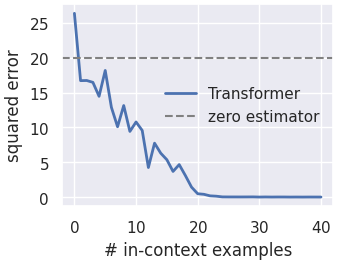

In [85]:
metric = task.get_metric()
loss = metric(pred, ys).numpy()

sparsity = conf.training.task_kwargs.sparsity if "sparsity" in conf.training.task_kwargs else None
baseline = {
    "linear_regression": n_dims,
    "sparse_linear_regression": sparsity,
    "relu_2nn_regression": n_dims,
    "decision_tree": 1,
}[conf.training.task]

plt.plot(loss.mean(axis=0), lw=2, label="Transformer")
plt.axhline(baseline, ls="--", color="gray", label="zero estimator")
plt.xlabel("# in-context examples")
plt.ylabel("squared error")
plt.legend()
# plt.title(f"Task: {conf.training.task}, Model: {conf.model}")
plt.savefig(f"../imgs/Task: {conf.training.task}, Model: {conf.model}.png")
plt.show()

As an exploration example, let's see how robust the model is to doubling all the inputs.

In [86]:
xs2 = 2 * xs
ys2 = task.evaluate(xs2)
with torch.no_grad():
    pred2 = model(xs2, ys2)

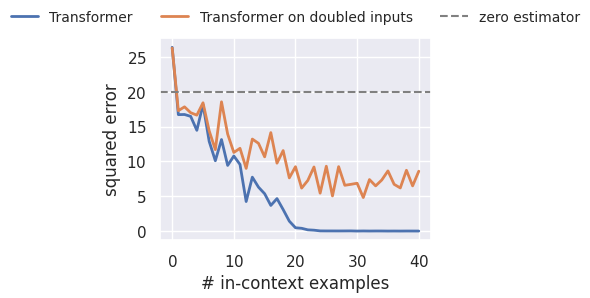

In [87]:
loss2 = metric(pred2, ys2).numpy()

plt.plot(loss.mean(axis=0), lw=2, label="Transformer")
plt.plot(loss2.mean(axis=0) / 4, lw=2, label="Transformer on doubled inputs")
plt.axhline(baseline, ls="--", color="gray", label="zero estimator")
plt.xlabel("# in-context examples")
plt.ylabel("squared error")
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.2), ncol=3, fontsize=10)
plt.savefig(f"../imgs/Task: {conf.training.task}, Model: {conf.model} - doubled inputs.png")
plt.show()

The error does increase, especially when the number of in-context examples exceeds the dimension, but the model is still relatively accurate.